In [1]:
import numpy as np
from qiskit.quantum_info import random_clifford, Pauli

In [4]:
import numpy as np
from itertools import product

# Define Pauli matrices and identity matrix
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# List of matrices and their labels
paulis = [I, X, Y, Z]
pauli_labels = ['I', 'X', 'Y', 'Z']
pauli_dict = {tuple(map(tuple, I)): 'I', tuple(map(tuple, X)): 'X', tuple(map(tuple, Y)): 'Y', tuple(map(tuple, Z)): 'Z'}

# Function to compute the Hilbert-Schmidt norm
def hilbert_schmidt_norm(matrix):
    return np.sqrt(np.trace(matrix.conj().T @ matrix))

# Generate all tensor products for a 3-qubit system
results = []
for combo in product(paulis, repeat=3):
    label = ''.join(pauli_dict[tuple(map(tuple, m))] for m in combo)
    tensor_product = np.kron(np.kron(combo[0], combo[1]), combo[2])
    norm = hilbert_schmidt_norm(tensor_product)
    results.append((label, norm))

# Write results to a text file
with open('output/hilbert_schmidt_norms.txt', 'w') as f:
    for label, norm in results:
        f.write(f"{label}: {norm.real}\n")

print("Hilbert-Schmidt norms have been written to hilbert_schmidt_norms.txt")


Hilbert-Schmidt norms have been written to hilbert_schmidt_norms.txt


In [5]:
import numpy as np
from itertools import product

# Define Pauli matrices and identity matrix
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# List of matrices and their labels
paulis = [I, X, Y, Z]
pauli_labels = ['I', 'X', 'Y', 'Z']
pauli_dict = {tuple(map(tuple, I)): 'I', tuple(map(tuple, X)): 'X', tuple(map(tuple, Y)): 'Y', tuple(map(tuple, Z)): 'Z'}

# Function to compute the Hilbert-Schmidt norm
def hilbert_schmidt_norm(matrix):
    return np.sqrt(np.trace(matrix.conj().T @ matrix))

# Generate all tensor products for a 3-qubit system
results = []
for combo in product(paulis, repeat=3):
    label = ''.join(pauli_dict[tuple(map(tuple, m))] for m in combo)
    tensor_product = np.kron(np.kron(combo[0], combo[1]), combo[2])
    norm = hilbert_schmidt_norm(tensor_product)
    results.append((label, norm))

# Filter results for lower locality (more identity matrices)
lower_locality_results = [result for result in results if result[0].count('I') >= 1]

# Write results to a text file
with open('output/lower_locality_hilbert_schmidt_norms.txt', 'w') as f:
    for label, norm in lower_locality_results:
        f.write(f"{label}: {norm.real}\n")

print("Hilbert-Schmidt norms for lower locality observables have been written to lower_locality_hilbert_schmidt_norms.txt")


Hilbert-Schmidt norms for lower locality observables have been written to lower_locality_hilbert_schmidt_norms.txt


In [2]:
def tensor_prod(*tensors):
    if len(tensors) == 2:
        return np.kron(tensors[0], tensors[1])
    else:
        return np.kron(tensors[0], tensor_prod(*tensors[1:]))
    
def hermitian(matrix):
    return np.allclose(matrix, matrix.conj().T)

def trace_one(matrix):
    return np.isclose(np.trace(matrix), 1)

def positive_semi_definite(matrix, tol=1e-8):
    return np.all(np.linalg.eigvals(matrix) + tol >= 0)

def is_legal(matrix):
    return hermitian(matrix) and trace_one(matrix) and positive_semi_definite(matrix)

def int_to_bin_list(n, length):
    bin_list = np.zeros(length)
    bin_list[n] = 1
    return bin_list

def single_sample(prob_list):
    assert np.isclose(sum(prob_list), 1), "probability does not sum up to 1"
    rd = np.random.random()
    inf, sup = 0, 0
    for i, e in enumerate(prob_list):
        sup += e
        if inf <= rd <= sup:
            return i
        else:
            inf = sup
    raise ValueError("random value does not meet any interval")

In [3]:
class QuantumState():
    def __init__(self, num_qubits:int, num_shots:int, batch_size:int, pauli_observables:list, veri:bool):
        self._num_qubits = num_qubits
        self._observables = pauli_observables
        self._batch_size = batch_size
        self._num_shots = num_shots
        self._veri = veri
        self._dm = None
        self._entangled = None
        
    @property
    def dm(self):
        return self._dm
    
    @dm.setter
    def dm(self, new_dm):
        if not (self._veri or is_legal(new_dm)):
            raise ValueError("density matrix is not physical")
        else:
            self._dm = new_dm
    
    def set_dm(self):
        raise NotImplementedError("without information to construct density matrix")
    
    def random_evolve(self):
        self._U = random_clifford(self._num_qubits).to_matrix()
        self._dm = self._U @ self.dm @ np.conj(self._U).T
    
    def single_shot_measure(self):
        prob_list = [self._dm[i, i] for i in range(2 ** self._num_qubits)]
        single_shot_state = int_to_bin_list(single_sample(prob_list), 2 ** self._num_qubits)
        del self._dm
        self._state = single_shot_state
    
    def reconstruct_dm(self):
        dim = 2 ** self._num_qubits
        return (dim + 1) * (np.conj(self._U).T @ np.outer(self._state, self._state) @ self._U) - np.eye(dim)

    # def classical_shadow(self):
    #     shadows = {obs: [] for obs in self._observables}
    #     temp_shadows = {obs: [] for obs in self._observables}
    #     dm_copy = self._dm
    #     for _ in range(self._num_shots // self._batch_size):
    #         for _ in range(self._batch_size):
    #             self._dm = dm_copy
    #             self.random_evolve()
    #             self.single_shot_measure()
    #             rdm = self.reconstruct_dm()
    #             for k, v in temp_shadows.items():
    #                 v.append(np.trace(Pauli(k).to_matrix() @ rdm))
    #         for k, v in shadows.items():
    #             v.append(np.mean(temp_shadows[k]))
    #         temp_shadows = {obs: [] for obs in self._observables}
    #     del temp_shadows
    #     return {k: np.median(v) for k, v in shadows.items()}
    
    def classical_shadow(self):
        shadows = {obs: [] for obs in self._observables}
        dm_copy = self._dm
        for _ in range(self._num_shots // self._batch_size):
            snapshots = []
            for _ in range(self._batch_size):
                self._dm = dm_copy
                self.random_evolve()
                self.single_shot_measure()
                snapshots.append(self.reconstruct_dm())
            mean = np.mean(np.stack(snapshots), axis=0)
            for k, v in shadows.items():
                v.append(np.trace(Pauli(k).to_matrix() @ mean))
        return {k: np.median(v) for k, v in shadows.items()}

In [16]:
targets = ['II', 'III', 'IIII', 'IIIII', 'IIIIII', 'IIIIIII']
num_shots = 10000
state_0 = np.array([[1],
                    [0]])
state_1 = np.array([[0],
                    [1]])
for i in range(6):
    num_qubits = 2 + i
    state = [state_0] * num_qubits
    state = tensor_prod(*state)
    state = np.outer(state, state)
    test_qstate = QuantumState(num_qubits, 10000, 50, [targets[i]], False)
    test_qstate.dm = state
    print(f"{i+2} qubits: (theoretical) {np.trace(state @ Pauli(targets[i]).to_matrix())}")
    print(f"{i+2} qubits: (CS) {test_qstate.classical_shadow()}")

2 qubits: (theoretical) (1+0j)
2 qubits: (CS) {'II': np.complex128(0.9999999999999982+0j)}
3 qubits: (theoretical) (1+0j)
3 qubits: (CS) {'III': np.complex128(0.9999999999999908+2.6655398962266124e-18j)}
4 qubits: (theoretical) (1+0j)
4 qubits: (CS) {'IIII': np.complex128(0.9999999999999846-1.6551142912828616e-20j)}
5 qubits: (theoretical) (1+0j)
5 qubits: (CS) {'IIIII': np.complex128(0.9999999999999523-5.688119052100902e-18j)}
6 qubits: (theoretical) (1+0j)
6 qubits: (CS) {'IIIIII': np.complex128(0.9999999999998688+0j)}
7 qubits: (theoretical) (1+0j)
7 qubits: (CS) {'IIIIIII': np.complex128(0.9999999999996587+0j)}


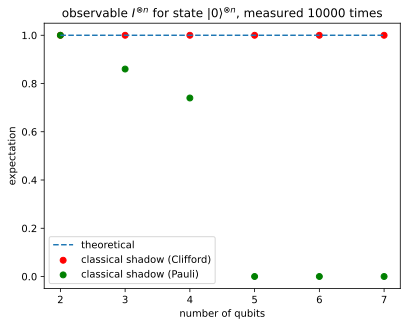

In [34]:
import matplotlib.pyplot as plt
x = [2, 7]
y = [1, 1]
xdata = [2, 3, 4, 5, 6, 7]
yfdata = [1, .86, .74, 0, 0, 0]
ydata = [1] * 6
plt.plot(x, y, linestyle='--', label='theoretical')  
plt.scatter(xdata, ydata, color='red', label='classical shadow (Clifford)')
plt.scatter(xdata, yfdata, color='green', label='classical shadow (Pauli)')
plt.xlabel('number of qubits')
plt.ylabel('expectation')
plt.legend()
plt.title(r'observable $I^{\otimes n}$ for state $ |0 \rangle ^{\otimes n}$, measured 10000 times')
plt.savefig('output/fig1.png', dpi=240)
plt.show()
